In [4]:
from sklearn.cluster import KMeans
from scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle

## Train HMM

In [78]:
def trainKMeans(data_dir, M):    
    data = np.array([])
#     print("Loading training data...")
    for filename in os.listdir(data_dir):
        if filename.endswith(".txt"):
#             if gestureType not in filename:
#                 continue
            temp = np.loadtxt(data_dir + filename)
    #         print(temp.shape)
            if len(data) == 0:
                data = temp[:,1:]
            else:
                data = np.concatenate((data, temp[:,1:]))
    #         print(data.shape)
    #         print(data)
            kmeans = KMeans(n_clusters=M).fit(data)
#     print("Done!")

    plt.figure(figsize=(16, 12))
    for i in range(data.shape[1] - 1):
        plt.scatter(data[:,i], data[:,i+1], c=kmeans.labels_.astype(float), s=0.4)
    for i in range(data.shape[1] - 1):
        plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,i+1], c='r', s=10)
    return kmeans

In [7]:
# fig = plt.figure(figsize=(16, 12))
# ax = fig.add_subplot(projection='3d')
# for i in range(data.shape[1] - 2):
#     plt.scatter(data[:,i], data[:,i+1], data[:,i+2], c=kmeans.labels_.astype(float))
# for i in range(data.shape[1] - 2):
#     plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,i+1], kmeans.cluster_centers_[:,i+2], c='r')
# # plt.scatter(data[:,0], data[:,1])

In [8]:
def forward(O, A, B, pi):
    # alpha[t][i] where 1 < t < len(O), 1 < i < len(A)
    alpha = np.zeros([len(O), len(A)])
    alphaDots = np.zeros([len(O), len(A)])
    alphaHat = np.zeros([len(O), len(A)])
    c = np.zeros(len(O))
    alpha[0, :] = pi * B[:, int(O[0])]
    alphaDots[0] = alpha[0]
    c[0] = 1 / np.sum(alphaDots[0])
    alphaHat[0] = c[0] * alphaDots[0]
    for t in range(1, len(O)):
        for i in range(len(A)):
#             No scaling
#             alpha[t, i] = alpha[t - 1].dot(A[i] * B[i, int(O[t])])
#             Scaling
            alphaDots[t, i] = (alphaHat[t - 1]).dot(A[i] * B[i, int(O[t])])
        c[t] = 1 / np.sum(alphaDots[t])
        alphaHat[t] = c[t] * alphaDots[t]
    
    return alphaHat, c

In [9]:
def backward(O, A, B, c):
    beta = np.zeros([len(O), len(A)])
    betaHat = np.zeros([len(O), len(A)])
    beta[len(O) - 1] = np.ones(len(A))
    betaHat[-1] = c[-1] * beta[-1]
    for t in reversed(range(len(O) - 1)):
        for i in range(len(A)):
#             No scaling
#             beta[t][i] = A[:, i].dot(B[:, int(O[t + 1])] * beta[t + 1])
#             Scaling
            beta[t][i] = A[:, i].dot(B[:, int(O[t + 1])] * betaHat[t + 1])
        betaHat[t] = c[t] * beta[t]
    
    return betaHat

In [10]:
def EStep(O, A, B, alpha, beta, c):
    gamma = np.zeros([len(O), len(A)])
    for t in range(len(O)):
        denominator = alpha[t].dot(beta[t])
        for i in range(len(A)):
            numerator = alpha[t, i] * beta[t, i]
            gamma[t,i] = numerator / denominator
    
    zeta = np.zeros([len(O), len(A), len(A)])
    for t in range(len(O) - 1):
        denominator = 0
        for i in range(len(A)):
            for j in range(len(A)):
                denominator += alpha[t, i] * A[j, i] * B[j, int(O[t+1])] * beta[t+1, j]
        for i in range(len(A)):
            for j in range(len(A)):
#                 print(B.shape, j, O[t+1])
                numerator = alpha[t, i] * A[j, i] * B[j, int(O[t+1])] * beta[t + 1, j]
                zeta[t, i, j] = numerator / denominator
    
    return gamma, zeta
    

In [11]:
def MStep(O, A, B, gamma, zeta, c, alpha, beta):
    for i in range(len(A)):
        for j in range(len(A)):
            numerator = 0
            denominator = np.sum(zeta[:-1, i, :])
            numerator = np.sum(zeta[:, i, j])
            A[j, i] = numerator / denominator

        for o in range(len(B[0])):
            numerator = 0
            denominator = 0
            for t in range(len(O)):
                if O[t] == o:
                    numerator += gamma[t][i]
            B[i][o] = numerator / np.sum(gamma[:, i])
    
    return A, B

In [63]:
def baum_welch(O, A, B, pi, lMax):
    likelihood = []
    for l in range(lMax):
        print("Loop " + str(l + 1) + " / " + str(lMax))
        alpha, c = forward(O, A, B, pi)
#         print("Alpha done")
        beta = backward(O, A, B, c)
        for i in range(len(B)):
            for j in range(len(B[0])):
                if B[i, j] == 0:
                    B[i, j] = 1e-8
#         print("Beta done")
        
        gamma, zeta = EStep(O, A, B, alpha.copy(), beta.copy(), c)
#         print("EStep done")
        A, B = MStep(O, A, B, gamma, zeta, c, alpha, beta)
#         print("MStep done")
        for i in range(len(B)):
            for j in range(len(B[0])):
                if B[i, j] == 0:
                    B[i, j] = 1e-8
        p = 0
        for ct in c:
            p += math.log(ct)
        likelihood.append(-p)
    fig = plt.figure
    plt.plot(range(lMax), likelihood)
#     Check alphas
#     for t in range(len(O)):
#         print(alpha[t] / np.prod(c[:t+1]))
#     Check betas
#     for t in range(len(O)):
#         print(beta[t] / np.prod(c[t:]))
    
    
    return A, B

In [76]:
def buildHMM(gestureType, data_dir, K, M, pi, kmeansTrain):
    print("Building HMM for " + gestureType + "...")
    data = testKMeans(data_dir, gestureType, kmeansTrain)
#     data = np.atleast_2d(kmeans.labels_.astype(int)).T
    
    # Generate A as left to right transition matrix
    A = np.zeros([K, K])
    A[0, 0] = 0.5
    A[0, -1] = 0.5
    for i in range(K - 1):
        A[i + 1, i] = 0.5
        A[i + 1, i + 1] = 0.5
    
    # Generate B as randoms
    B = np.random.rand(K, M)
    for row in range(len(B)):
    #     print(np.sum(B[row]))
        B[row] = B[row] / np.sum(B[row])
    A, B = baum_welch(data.copy(), A.copy(), B.copy(), pi.copy(), 100)
    print("Done!")

    return A, B, kmeans
    

# Test Trained Data

In [20]:
def testKMeans(data_dir, gesture, kmeans):
    data = np.array([])
#     print("Loading training data...")
    for filename in os.listdir(data_dir):
        if gesture not in filename:
            continue
        temp = np.loadtxt(data_dir + filename)
    #     print(temp.shape)
        if len(data) == 0:
            data = temp[:,1:]
        else:
            data = np.concatenate((data, temp[:,1:]))

    kmeansTest = kmeans.predict(data)
#     print("Done!")
    
#     plt.figure(figsize=(16, 12))
#     for i in range(data.shape[1] - 1):
#         plt.scatter(data[:,i], data[:,i+1], c=kmeansTest, s=0.4)
#     for i in range(data.shape[1] - 1):
#         plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,i+1], c='r', s=10)
#     # plt.scatter(data[:,0], data[:,1])
    data = np.atleast_2d(kmeansTest).T
    return data

In [89]:
# data_dir = "ECE5242Proj2-test/"
# filename = "test1.txt"
def evaluate(data_dir, filename):
    # Unpack HMMs
    hmms = pickle.load(open("hmms100.pickle", "rb"))
    pi = hmms[0]
    waveA, waveB, kmeansWave = hmms[1]
    circleA, circleB, kmeansCircle = hmms[2]
    eightA, eightB, kmeansEight = hmms[3]
    infA, infB, kmeansInf = hmms[4]
    beat3A, beat3B, kmeansBeat3 = hmms[5]
    beat4A, beat4B, kmeansBeat4 = hmms[6]
    # Get test clusters
    # testData = testKMeans(data_dir, filename, kmeansEight)
    key = ["Wave", "Circle", "Eight", "Inf", "Beat3", "Beat4"]

    # Test for wave
    testData = testKMeans(data_dir, filename, kmeansWave)
    waveScore = score(testData, waveA, waveB, pi)
    # Test for circle
    testData = testKMeans(data_dir, filename, kmeansCircle)
    circleScore = score(testData, circleA, circleB, pi)
    # Test for eight
    testData = testKMeans(data_dir, filename, kmeansEight)
    eightScore = score(testData, eightA, eightB, pi)
    # Test for inf
    testData = testKMeans(data_dir, filename, kmeansInf)
    infScore = score(testData, infA, infB, pi)
    # Test for beat3
    testData = testKMeans(data_dir, filename, kmeansBeat3)
    beat3Score = score(testData, beat3A, beat3B, pi)
    # Test for beat4
    testData = testKMeans(data_dir, filename, kmeansBeat4)
    beat4Score = score(testData, beat4A, beat4B, pi)

    scores = [waveScore, circleScore, eightScore, infScore, beat3Score, beat4Score]
    for idx in range(len(scores)):
        if np.isnan(scores[idx]):
            scores[idx] = -float('inf')

    pairs = sorted(zip(scores, key), reverse=True)
    for pair in pairs:
        print(pair[1] + " Score: " + str(pair[0]))

    maxIdx = scores.index(max(scores))
    print("Detected Gesture: " + pairs[0][1])

In [16]:
def score(data, A, B, pi):
    alpha, c = forward(data, A, B, pi)
    p = 0
    for ct in c:
        p += math.log(ct)
    return -p

# Test With Toy Data

In [1408]:
X=np.concatenate((np.zeros((1000,1)),np.random.randint(0,2,size=(1000,1)),np.zeros((1000,1))))
# Y = np.array([[0, 1]*50]).T
# X=np.concatenate((np.zeros((100,1)),Y,np.zeros((100,1))))
# print(Y)
X.shape

(3000, 1)

In [ ]:
K = 2
M = 2
A = np.ones([K, K])
# A = np.array([[.25, .75], [0.5, 0.5]])
A = A / len(A)

# B = np.ones([K, M])
# B = B / len(B[0])
B = np.array([[.25, .75], [0.5, 0.5]])
pi = np.zeros(K)
pi[0] = 1
A, B = baum_welch(X.copy(), A.copy(), B.copy(), pi.copy(), 20)

A.T, B

# Build HMM for Each Gesture

Building KMeans of all data...
Done!
Building HMM for wave...
Loop 1 / 100
Loop 2 / 100
Loop 3 / 100
Loop 4 / 100
Loop 5 / 100
Loop 6 / 100
Loop 7 / 100
Loop 8 / 100
Loop 9 / 100
Loop 10 / 100
Loop 11 / 100
Loop 12 / 100
Loop 13 / 100
Loop 14 / 100
Loop 15 / 100
Loop 16 / 100
Loop 17 / 100
Loop 18 / 100
Loop 19 / 100
Loop 20 / 100
Loop 21 / 100
Loop 22 / 100
Loop 23 / 100
Loop 24 / 100
Loop 25 / 100
Loop 26 / 100
Loop 27 / 100
Loop 28 / 100
Loop 29 / 100
Loop 30 / 100
Loop 31 / 100
Loop 32 / 100
Loop 33 / 100
Loop 34 / 100
Loop 35 / 100
Loop 36 / 100
Loop 37 / 100
Loop 38 / 100
Loop 39 / 100
Loop 40 / 100
Loop 41 / 100
Loop 42 / 100
Loop 43 / 100
Loop 44 / 100
Loop 45 / 100
Loop 46 / 100
Loop 47 / 100
Loop 48 / 100
Loop 49 / 100
Loop 50 / 100
Loop 51 / 100
Loop 52 / 100
Loop 53 / 100
Loop 54 / 100
Loop 55 / 100
Loop 56 / 100
Loop 57 / 100
Loop 58 / 100
Loop 59 / 100
Loop 60 / 100
Loop 61 / 100
Loop 62 / 100
Loop 63 / 100
Loop 64 / 100
Loop 65 / 100
Loop 66 / 100
Loop 67 / 100
Loop 68 /

Loop 74 / 100
Loop 75 / 100
Loop 76 / 100
Loop 77 / 100
Loop 78 / 100
Loop 79 / 100
Loop 80 / 100
Loop 81 / 100
Loop 82 / 100
Loop 83 / 100
Loop 84 / 100
Loop 85 / 100
Loop 86 / 100
Loop 87 / 100
Loop 88 / 100
Loop 89 / 100
Loop 90 / 100
Loop 91 / 100
Loop 92 / 100
Loop 93 / 100
Loop 94 / 100
Loop 95 / 100
Loop 96 / 100
Loop 97 / 100
Loop 98 / 100
Loop 99 / 100
Loop 100 / 100
Done!


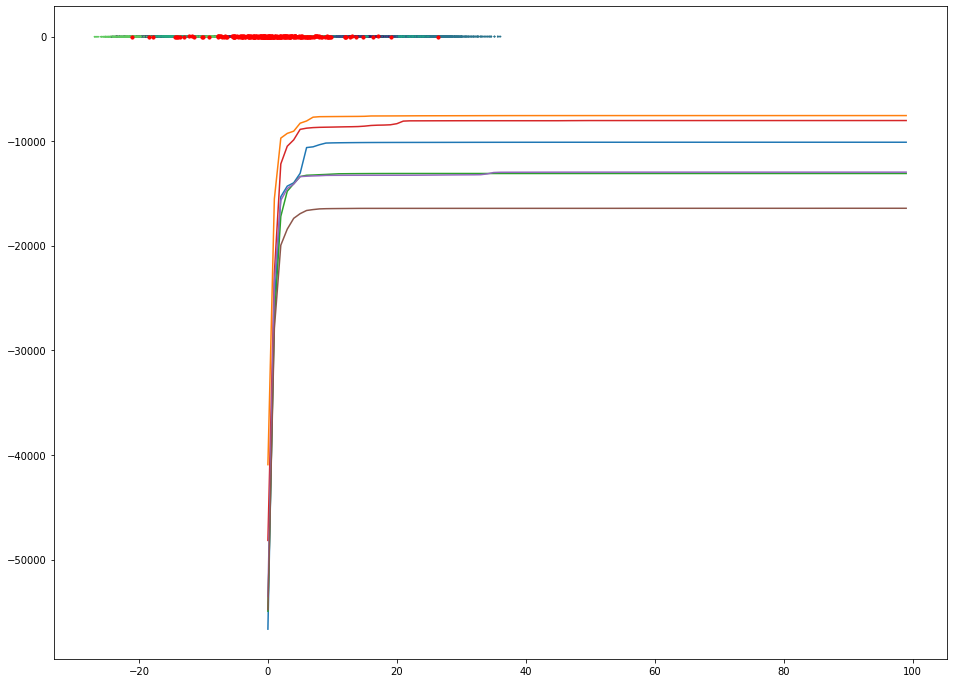

In [79]:
K = 10
M = 50
pi = np.zeros(K)
pi[0] = 1
# pi = np.ones(K)
# pi /= K
out = [pi]
data_dir = "ECE5242Proj2-train/"

print("Building KMeans of all data...")
kmeans = trainKMeans(data_dir, M)
print("Done!")

waveA, waveB, kmeansWave = buildHMM("wave", data_dir, K, M, pi, kmeans)
out.append((waveA, waveB, kmeansWave))

circleA, circleB, kmeansCircle = buildHMM("circle", data_dir, K, M, pi, kmeans)
out.append((circleA, circleB, kmeansCircle))

eightA, eightB, kmeansEight = buildHMM("eight", data_dir, K, M, pi, kmeans)
out.append((eightA, eightB, kmeansEight))

infA, infB, kmeansInf = buildHMM("inf", data_dir, K, M, pi, kmeans)
out.append((infA, infB, kmeansInf))

beat3A, beat3B, kmeansBeat3 = buildHMM("beat3", data_dir, K, M, pi, kmeans)
out.append((beat3A, beat3B, kmeansBeat3))

beat4A, beat4B, kmeansBeat4 = buildHMM("beat4", data_dir, K, M, pi, kmeans)
out.append((beat4A, beat4B, kmeansBeat4))

pickle.dump(out, open("hmms.pickle", "wb"))

# Evaluate Unknown Gesture

In [1379]:
# wave50 = (waveA, waveB, kmeansWave)
# circle50 = (circleA, circleB, kmeansCircle)
# eight50 = (eightA, eightB, kmeansEight)
# inf50 = (infA, infB, kmeansInf)
# beat350 = (beat3A, beat3B, kmeansBeat3)
# beat450 = (beat4A, beat4B, kmeansBeat4)

In [90]:
test_dir = "ECE5242Proj2-test/"
for filename in os.listdir(test_dir):
    if filename.endswith(".txt"):
        print("Evaluation for " + filename + ":")
        evaluate(test_dir, filename)
        print("-------------------------------------")

Evaluation for test7.txt:
Eight Score: -4585.4648891108
Inf Score: -6324.246970258767
Beat3 Score: -8234.99495875906
Beat4 Score: -8302.148613233352
Wave Score: -11386.935671977146
Circle Score: -14036.558726891939
Detected Gesture: Eight
-------------------------------------
Evaluation for test6.txt:
Inf Score: -766.3598395066556
Eight Score: -4830.033672549272
Beat3 Score: -9057.08943885544
Beat4 Score: -10073.619730186236
Wave Score: -14791.505360064555
Circle Score: -15477.303949378706
Detected Gesture: Inf
-------------------------------------
Evaluation for test4.txt:
Beat4 Score: -1780.7851940844027
Beat3 Score: -6544.585048289448
Inf Score: -7617.860339456066
Wave Score: -8236.102008405396
Eight Score: -12316.72627938073
Circle Score: -13988.94869824849
Detected Gesture: Beat4
-------------------------------------
Evaluation for test5.txt:
Circle Score: -2838.7759257775656
Beat3 Score: -5793.319778975688
Beat4 Score: -6346.606485259186
Eight Score: -12328.168192061734
Wave Scor

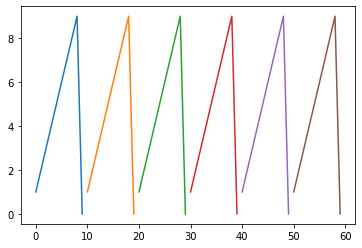

In [75]:
plt.plot(range(10), [1,2,3,4,5,6,7,8,9,0])
plt.plot(range(10, 20), [1,2,3,4,5,6,7,8,9,0])
plt.plot(range(20, 30), [1,2,3,4,5,6,7,8,9,0])
plt.plot(range(30, 40), [1,2,3,4,5,6,7,8,9,0])
plt.plot(range(40, 50), [1,2,3,4,5,6,7,8,9,0])
plt.plot(range(50, 60), [1,2,3,4,5,6,7,8,9,0])